# 군집화

주어진 데이터 집합을 유사한 데이터들의 그룹으로 나누는 것을 군집화(clustering)라 하고 이렇게 나누어진 유사한 데이터의 그룹을 군집(cluster)이라 한다. 

군집화는 예측 문제와 달리 특정한 독립변수와 종속변수의 구분도 없고 학습을 위한 목푯값도 필요로 하지 않는 비지도학습의 일종이다.

## 군집화 방법

군집화 방법에는 목적과 방법에 따라 다양한 모형이 존재한다. 

* K-평균 군집화(K-means Clustering)
* 디비스캔 군집화(DBSCAN Clustering)
* 유사도 전파 군집화(Affinity Propagation Clustering)
* 계층적 군집화(Hierarchical Clustering)
* 스펙트럴 군집화(Spectral Clustering)

군집화 방법은 사용법과 모수 등이 서로 다르다. 예를 들어 K-평균법이나 스펙트럴 군집화 등은 군집의 개수를 미리 지정해주어햐 하지만 디비스캔이나 유사도 전파법 등은 군집의 개수를 지정할 필요가 없다. 다만 이 경우에는 모형에 따라 특별한 모수를 지정해주어야 하는데 이 모수의 값에 따라 군집화 개수가 달라질 수 있다. 

다음은 몇가지 예제 데이터에 대해 위에서 나열한 군집화 방법을 적용한 결과이다. 같은 색상의 데이터는 같은 군집로 분류된 것이다.
그림에서 보다시피 각 군집화 방법마다 특성이 다르므로 원하는 목적과 데이터 유형에 맞게 사용해야 한다. 또한 지정된 모수의 값에 따라 성능이 달라질 수 있다. 이 결과는 최적화된 모수를 사용한 결과는 아니라는 점에 유의하라. 

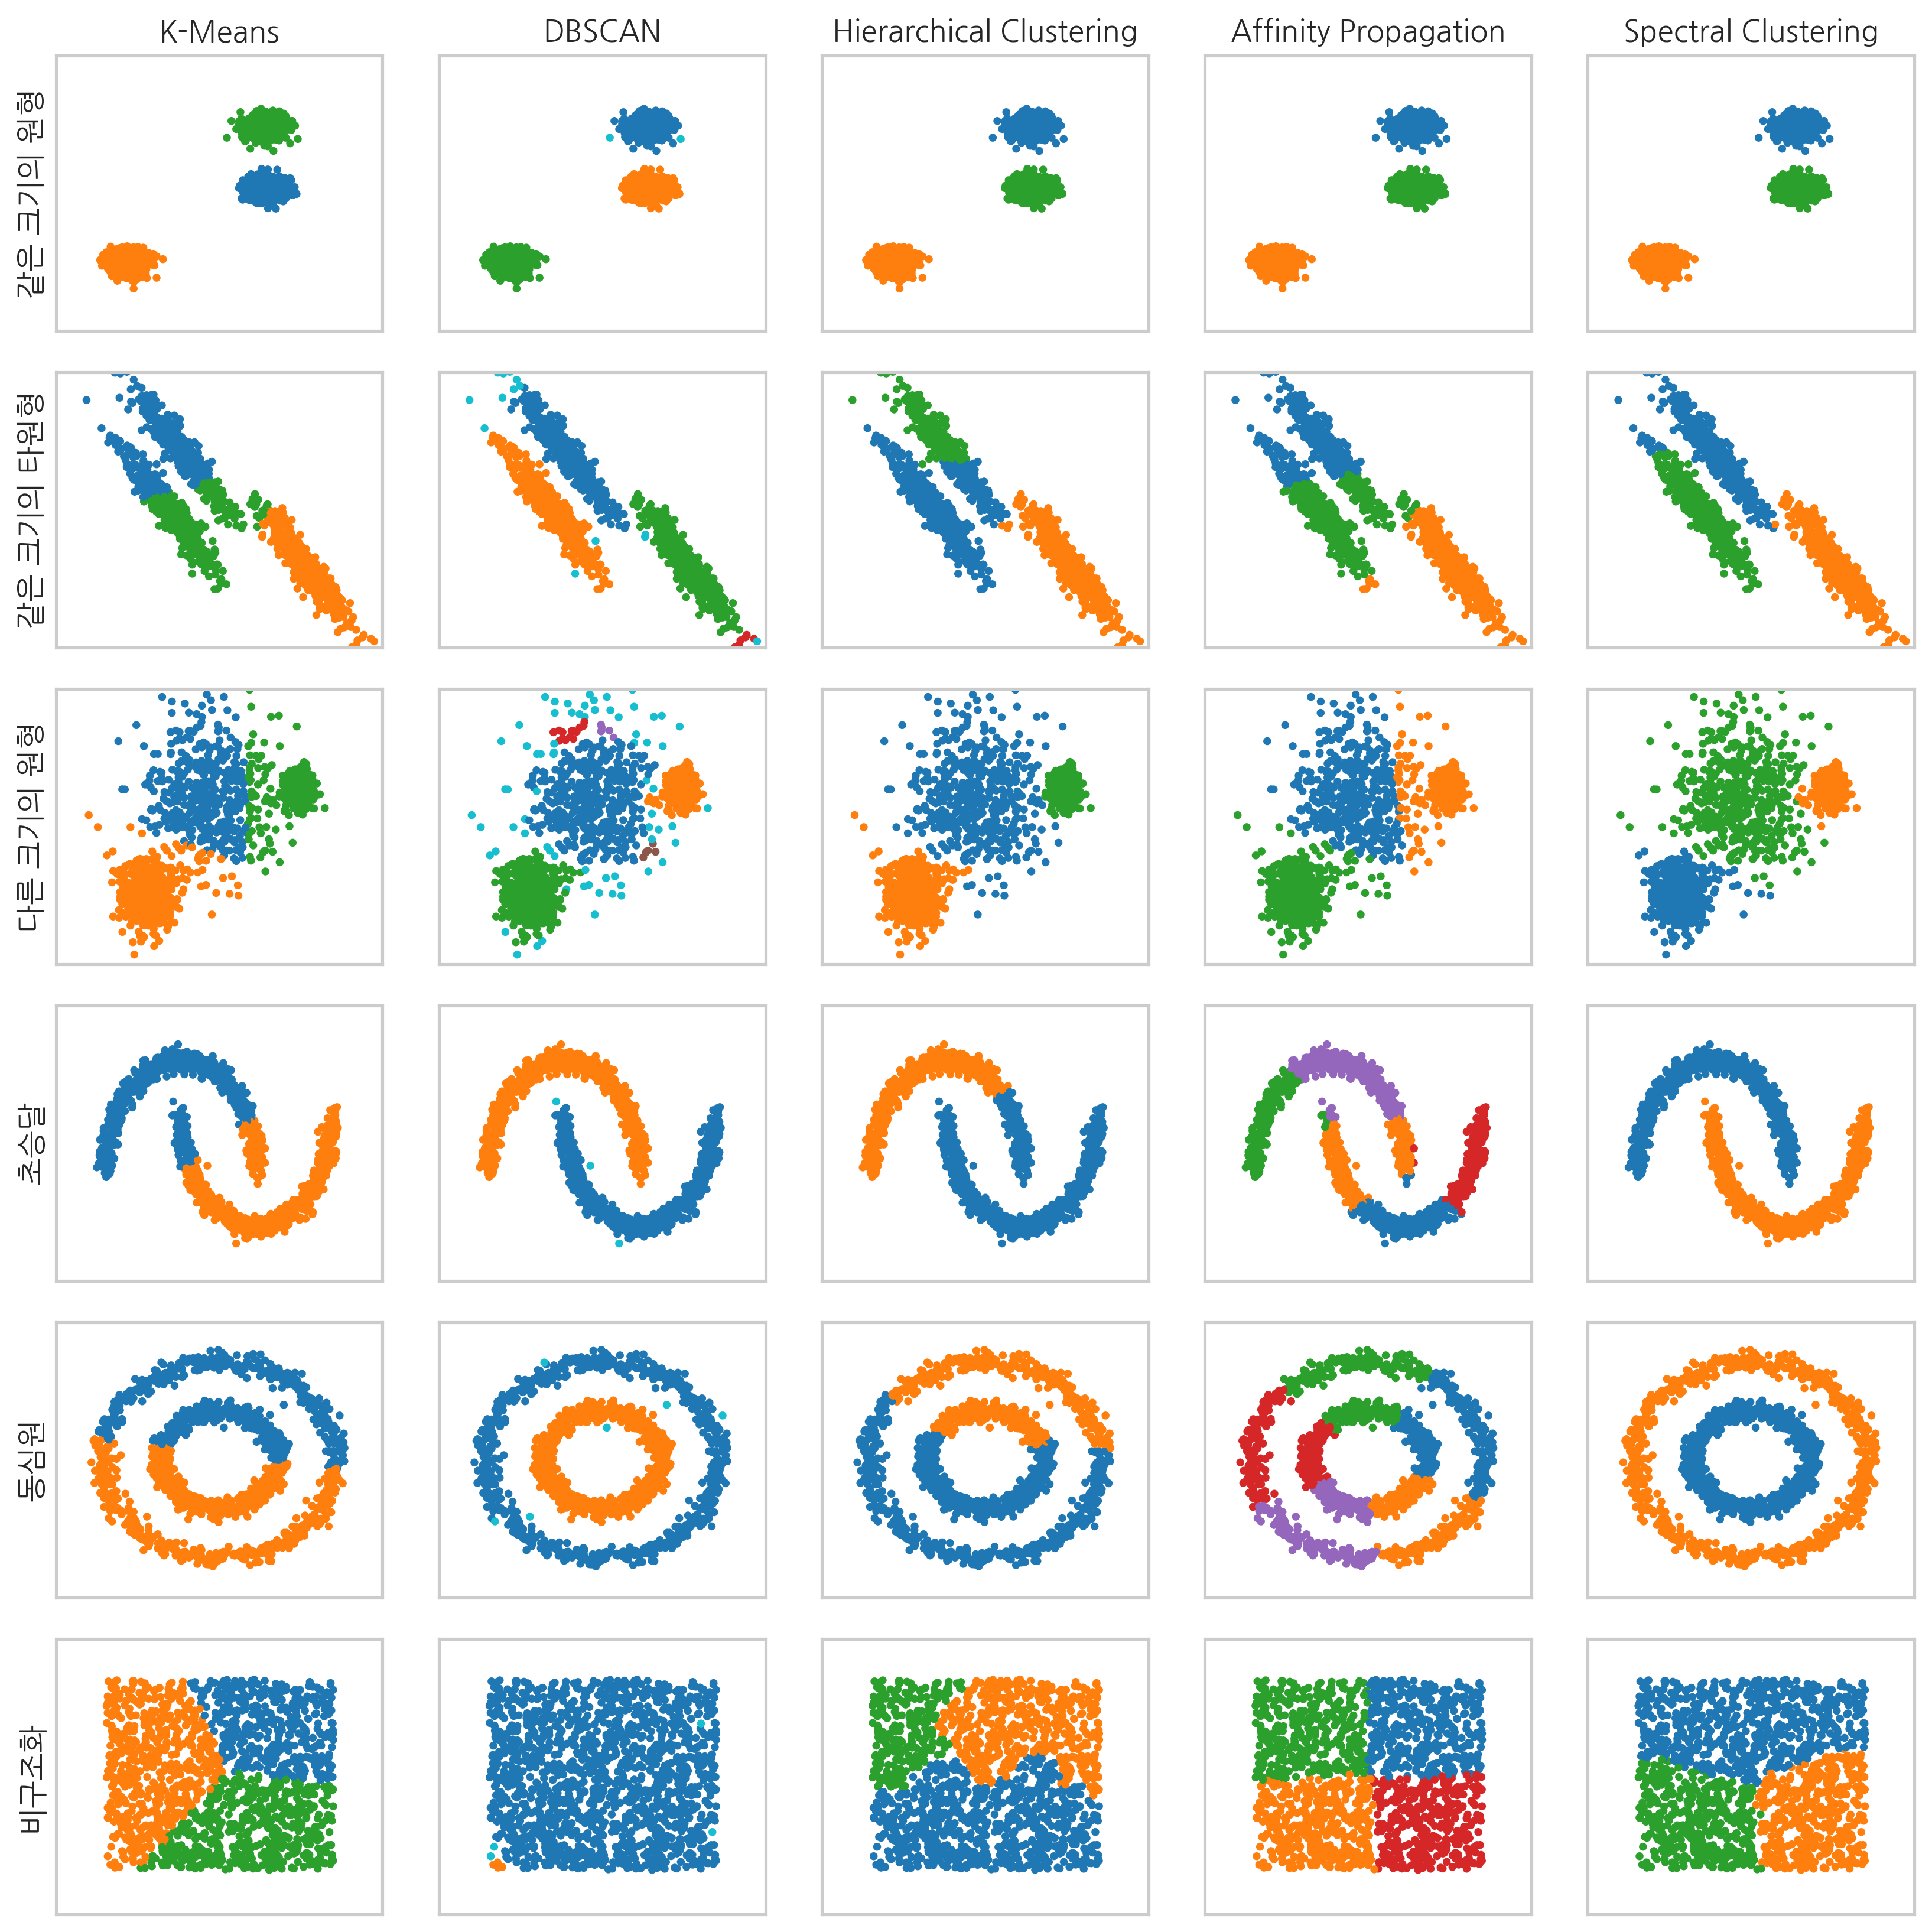

In [1]:
from sklearn.datasets import *
from sklearn.cluster import *
from sklearn.preprocessing import StandardScaler
from sklearn.utils.testing import ignore_warnings

np.random.seed(0)
n_samples = 1500
blobs = make_blobs(n_samples=n_samples, random_state=8)
X, y = make_blobs(n_samples=n_samples, random_state=170)
anisotropic = (np.dot(X, [[0.6, -0.6], [-0.4, 0.8]]), y)
varied = make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=170)
noisy_circles = make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = make_moons(n_samples=n_samples, noise=.05)
no_structure = np.random.rand(n_samples, 2), None
datasets = {
    "같은 크기의 원형": blobs, 
    "같은 크기의 타원형": anisotropic, 
    "다른 크기의 원형": varied, 
    "초승달": noisy_moons, 
    "동심원": noisy_circles, 
    "비구조화": no_structure
}

plt.figure(figsize=(11, 11))
plot_num = 1
for i, (data_name, (X, y)) in enumerate(datasets.items()):
    if data_name in ["초승달", "동심원"]:
        n_clusters = 2
    else:
        n_clusters = 3

    X = StandardScaler().fit_transform(X)

    two_means = MiniBatchKMeans(n_clusters=n_clusters)
    dbscan = DBSCAN(eps=0.15)
    spectral = SpectralClustering(n_clusters=n_clusters, affinity="nearest_neighbors")
    ward = AgglomerativeClustering(n_clusters=n_clusters)
    affinity_propagation = AffinityPropagation(damping=0.9, preference=-200)
    clustering_algorithms = (
        ('K-Means', two_means),
        ('DBSCAN', dbscan),
        ('Hierarchical Clustering', ward),
        ('Affinity Propagation', affinity_propagation),
        ('Spectral Clustering', spectral),
    )

    for j, (name, algorithm) in enumerate(clustering_algorithms):
        with ignore_warnings(category=UserWarning):
            algorithm.fit(X)
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i == 0:
            plt.title(name)
        if j == 0:
            plt.ylabel(data_name)
        colors = plt.cm.tab10(np.arange(20, dtype=int))
        plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred])
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

plt.tight_layout()
plt.show()

## 군집화 성능기준

군집화의 경우에는 분류문제와 달리 성능기준을 만들기 어렵다. 심지어는 원래 데이터가 어떻게 군집화되어 있었는지를 보여주는 정답(groundtruth)이 있는 경우도 마찬가지이다. 따라서 다양한 성능기준이 사용되고 있다. 다음의 군집화 성능기준의 예다.

* 조정 랜드지수(Adjusted Rand Index)
* 조정 상호정보량 (Adjusted Mutual Information)
* 실루엣계수 (Silhouette Coefficient)


## 일치행렬 

랜드지수를 구하려면 데이터가 원래 어떻게 군집화되어 있어야 하는지를 알려주는 정답(groundtruth)이 있어야 한다. $N$개의 데이터 집합에서 $i$, $j$ 두 개의 데이터를 선택하였을 때 그 두 데이터가 같은 군집에 속하면 1 다른 데이터에 속하면 0이라고 하자. 이 값을 $N \times N$ 행렬 $T$로 나타내면 다음과 같다.

$$ 
T_{ij} = 
\begin{cases} 
1 & \text{ $i$와 $j$가 같은 군집} \\
0 & \text{ $i$와 $j$가 다른 군집} \\
\end{cases}
$$

예를 들어 $\{0, 1, 2, 3, 4 \}$라는 5개의 데이터 집합에서 $\{0, 1, 2 \}$와 $\{ 3, 4 \}$가 각각 같은 군집라면 행렬 $T$는 다음과 같다.

In [2]:
groundtruth = np.array([
    [1, 1, 1, 0, 0],
    [1, 1, 1, 0, 0],
    [1, 1, 1, 0, 0],
    [0, 0, 0, 1, 1],
    [0, 0, 0, 1, 1],
])

이제 군집화 결과를 같은 방법으로 행렬 $C$로 표시하자. 만약 군집화이 정확하다면 이 행렬은 정답을 이용해서 만든 행렬과 거의 같은 값을 가져야 한다. 만약 군집화 결과 $\{0, 1 \}$과 $\{ 2, 3, 4 \}$가 같은 군집라면 행렬 $C$는 다음과 같다.

In [3]:
clustering = np.array([
    [1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0],
    [0, 0, 1, 1, 1],
    [0, 0, 1, 1, 1],
    [0, 0, 1, 1, 1],
])

이 두 행렬의 모든 원소에 대해 값이 같으면 1 다르면 0으로 계산한 행렬을 일치행렬(incidence matrix)이라고 한다. 즉 데이터 집합에서 만들수 있는 모든 데이터 쌍에 대해 정답과 군집화 결과에서 동일한 값을 나타내면 1, 다르면 0이 된다. 

$$ 
R_{ij} = 
\begin{cases} 
1 & \text{ if } T_{ij} = C_{ij} \\
0 & \text{ if } T_{ij} \neq C_{ij} \\
\end{cases}
$$

즉, 원래 정답에서 1번 데이터와 2번 데이터가 같은(다른) 군집인데 군집화 결과에서도 같은(다른) 군집이라고 하면 $R_{12} = 1$이다.

위 예제에서 일치행렬을 구하면 다음과 같다.

In [4]:
incidence = 1 * (groundtruth == clustering)  # 1*는 True/False를 숫자 0/1로 바꾸기 위한 계산 
incidence

array([[1, 1, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 0, 1, 0, 0],
       [1, 1, 0, 1, 1],
       [1, 1, 0, 1, 1]])

이 일치 행렬은 두 데이터의 순서를 포함하므로 대칭행렬이다. 만약 데이터의 순서를 무시한다면 위 행렬에서 대각성분과 아래쪽 비대각 성분은 제외한 위쪽 비대각 성분만을 고려해야 한다. 위쪽 비대각 성분에서 1의 개수는 다음과 같아진다.

$$ 
a = \text{T에서 같은 군집에 있고 C에서도 같은 군집에 있는 데이터 쌍의 수}
$$

$$ 
b = \text{T에서 다른 군집에 있고 C에서도 다른 군집에 있는 데이터 쌍의 수}
$$


$$ 
\text{일치행렬 위쪽 비대각 성분에서 1의 개수} = a + b
$$

In [5]:
np.fill_diagonal(incidence, 0) # 대각성분 제외
a_plus_b = np.sum(incidence) / 2 # 대칭행렬이므로 절반만 센다.
a_plus_b

6.0

## 랜드지수

랜드지수(Rand Index, RI)는 가능한 모든 데이터 쌍의 개수에 대해 정답인 데이터 쌍의 개수의 비율로 정의한다. 

$$
\text{Rand Index} = \dfrac{a+b}{{}_NC_2}
$$

In [6]:
from scipy.special import comb
rand_index = a_plus_b / comb(incidence.shape[0], 2)
rand_index

0.6

## 조정 랜드지수

랜드지수는 0부터 1까지의 값을 가지고 1이 가장 좋은 성능을 뜻한다. 랜드지수의 문제점은 무작위로 군집화을 한 경우에도 어느 정도 좋은 값이 나올 가능성이 높다는 점이다. 즉 무작위 군집화에서 생기는 랜드지수의 기댓값이 너무 크다. 이를 해결하기 위해 무작위 군집화에서 생기는 랜드지수의 기댓값을 원래의 값에서 빼서 기댓값과 분산을 재조정한 것이 조정 랜드지수(adjusted Rand index, ARI)다. 

$$
\text{ARI} = 
\dfrac{\text{RI} - \text{E}[\text{RI}]}{\max(\text{RI}) - \text{E}[\text{RI}]}
$$

adjusted Rand index는 성능이 완벽한 경우 1이 된다. 반대로 가장 나쁜 경우로서 무작위 군집화을 하면 0에 가까운 값이 나온다. 경우에 따라서는 음수가 나올 수도 있다. 

위에서 예로 들었던 타원형 데이터 예제에 대해 여러가지 군집화 방법을 적용하였을때 조정 랜드지수를 계산해보면 디비스캔과 스펙트럴 군집화의 값이 높게 나오는 것을 확인할 수 있다. scikit-learn 패키지의 metrics.cluster 서브패키지는 조정 랜드지수를 계산하는 `adjusted_rand_score` 명령을 제공한다.

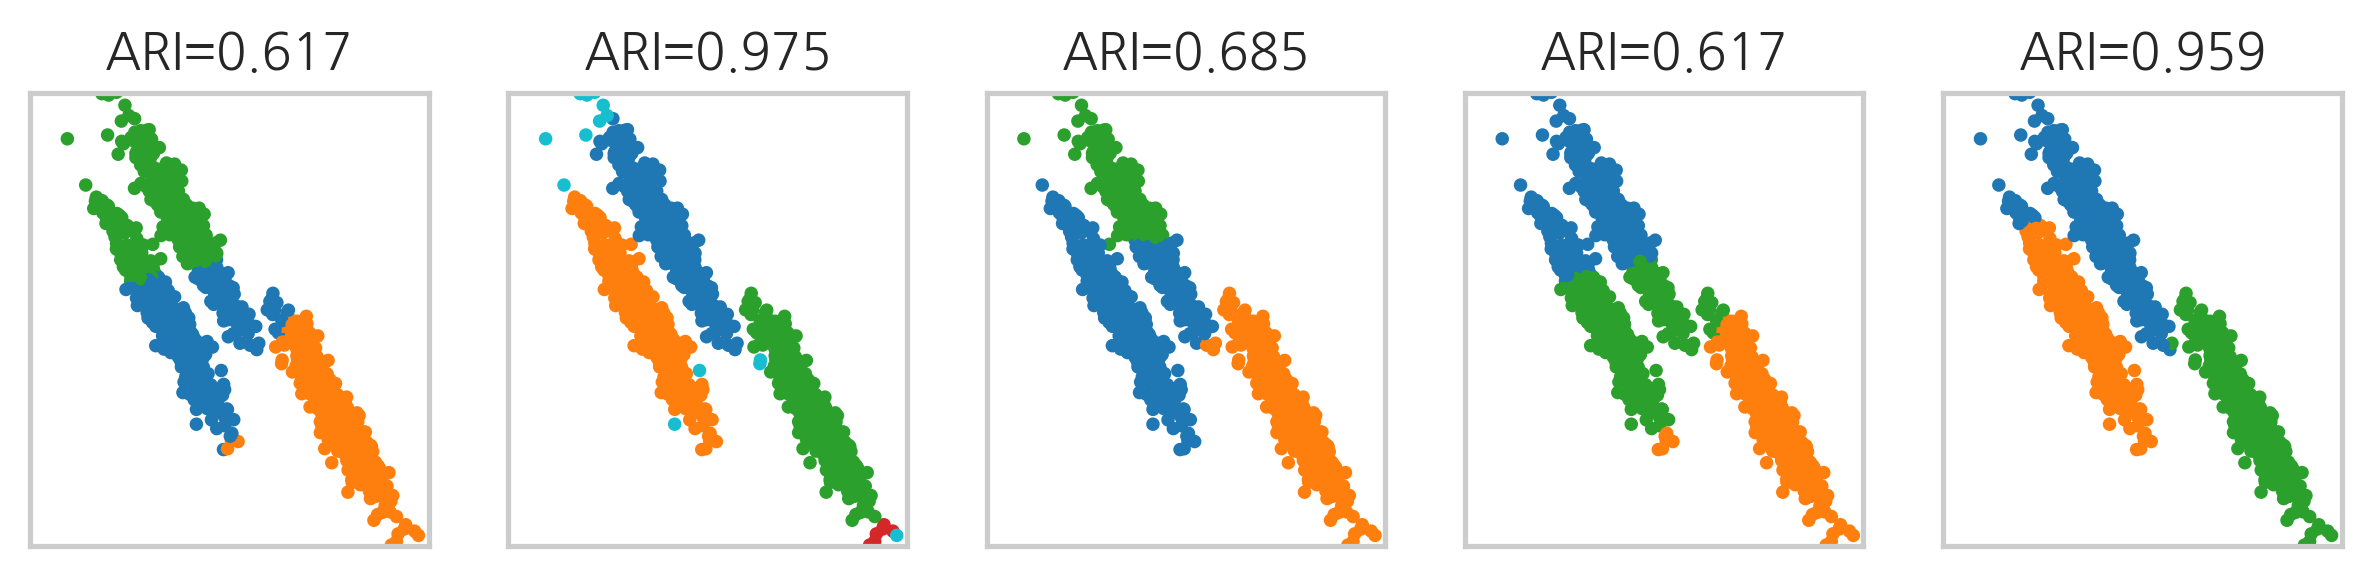

In [7]:
from sklearn.metrics.cluster import adjusted_rand_score

X, y_true = anisotropic

plt.figure(figsize=(12, 2))
plot_num = 1
X = StandardScaler().fit_transform(X)
for name, algorithm in clustering_algorithms:
    with ignore_warnings(category=UserWarning):
        algorithm.fit(X)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
    title = "ARI={:5.3f}".format(adjusted_rand_score(y_true, y_pred))
    plt.subplot(1, len(datasets), plot_num)
    plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred])
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plot_num += 1

## 조정 상호정보량

상호정보량(mutual information)은 두 확률변수간의 상호 의존성을 측정한 값이다. 군집화 결과를 이산확률변수라고 가정한다. 

정답은 

$$ T = \{T_1, T_2,\ldots, T_r\} $$

의 $r$개의 값을 가질 수 있는 이산확률변수이고 군집화 결과는 

$$ C = \{C_1, C_2,\ldots, C_s\} $$

의 $s$개의 값을 가질 수 있는 이산확률변수라고 하자.

전체 데이터의 개수를 $N$이라고 하면 이산확률변수 $T$의 분포는

$$ P(i)=\frac{|T_i|}{N} $$

로 추정할 수 있다. 이 식에서 $|T_i|$는 군집 $T_i$에 속하는 데이터의 개수를 나타낸다.

비슷하게 이산확률변수 $C$의 분포는

$$ P'(j)=\frac{|C_i|}{N} $$

라고 추정하고 $T$와 $C$의 결합확률분포는

$$ P(i,j)=\frac{|T_i \cap C_j|}{N} $$

라고 추정한다. 여기에서 $|T_i \cap C_j|$는 군집 $T_i$에도 속하고 군집 $C_j$에도 속하는 데이터의 개수를 나타낸다.

확률변수 $T, C$의 상호정보량은 

$$ MI(T,C)=\sum_{i=1}^r \sum_{j=1}^s P(i,j)\log \frac{P(i,j)}{P(i)P'(j)} $$

로 정의한다.

만약 두 확률변수가 서로 독립이면 상호정보량의 값은 0이며 이 값이 상호정보량이 가질 수 있는 최소값이다. 두 확률변수가 의존성이 강할수록 상호정보량은 증가한다. 또한 군집의 개수가 많아져도 상호정보량이 증가하므로 올바른 비교가 어렵다. 따라서 조정 랜드지수의 경우와 마찬가지로 각 경우에 따른 상호정보량의 기댓값을 빼서 재조정한 것이 조정 상호정보량이다.

다음은 위에서 예로 들었던 타원형 데이터 예제에 대해 여러가지 군집화 방법을 적용하였을때 조정 상호정보량 값을 계산한 결과이다. scikit-learn 패키지의 metrics.cluster 서브패키지는 조정 상호정보량을 계산하는 `adjusted_mutual_info_score` 명령을 제공한다.

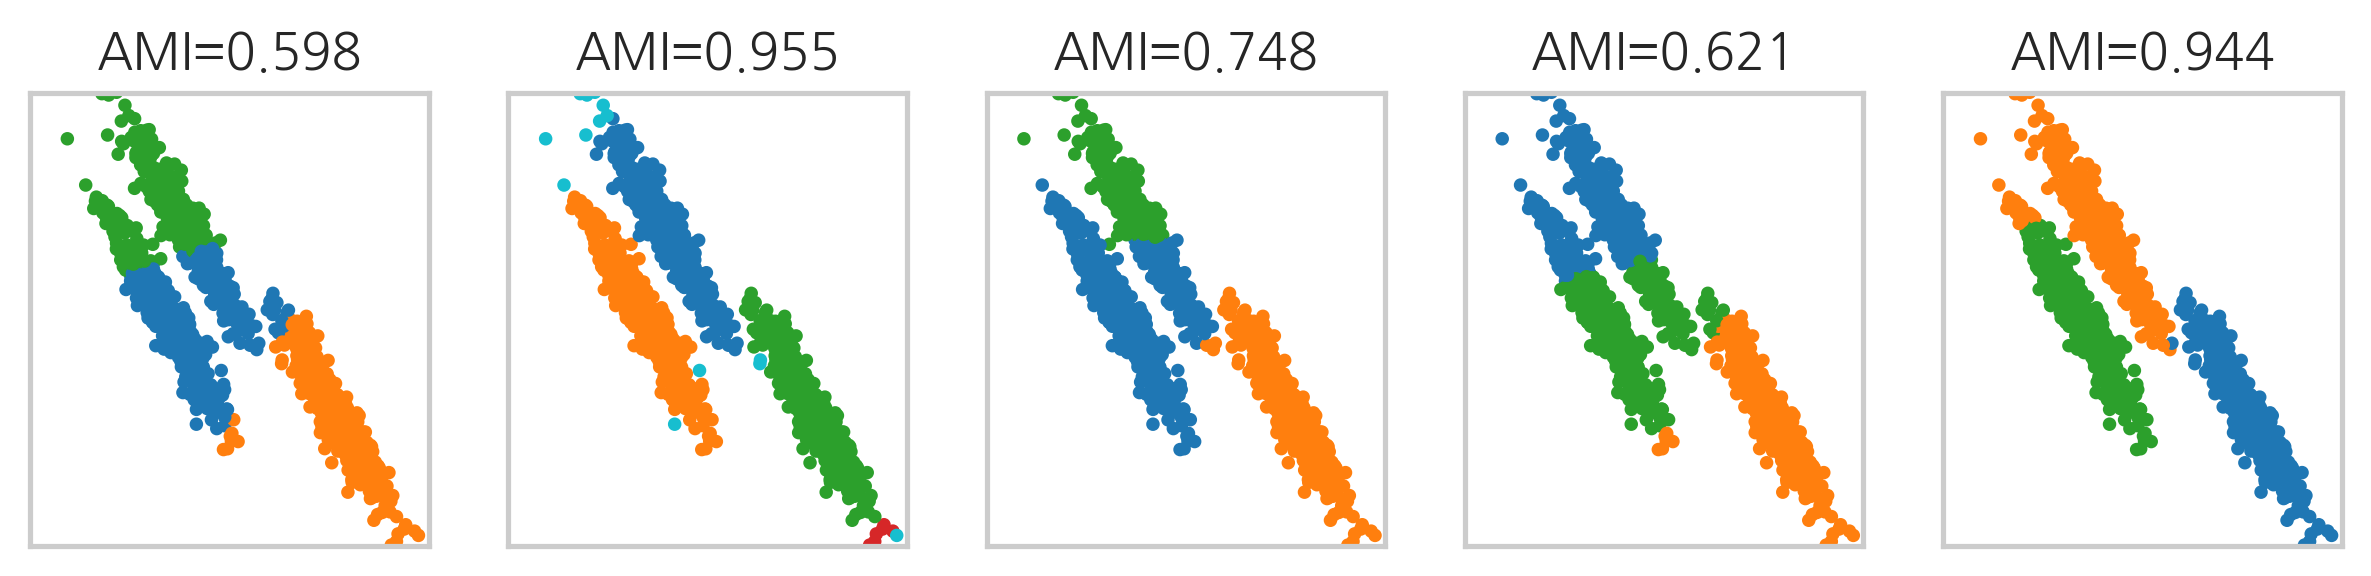

In [8]:
from sklearn.metrics.cluster import adjusted_mutual_info_score

X, y_true = anisotropic

plt.figure(figsize=(12, 2))
plot_num = 1
X = StandardScaler().fit_transform(X)
for name, algorithm in clustering_algorithms:
    with ignore_warnings(category=UserWarning):
        algorithm.fit(X)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
    title = "AMI={:5.3f}".format(adjusted_mutual_info_score(y_true, y_pred))
    plt.subplot(1, len(datasets), plot_num)
    plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred])
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plot_num += 1

## 실루엣계수

지금까지는 각각의 데이터가 원래 어떤 군집에 속해있었는지 정답(groundtruth)를 알고 있는 경우를 다루었다. 하지만 이러한 정답 정보가 없다면 어떻게 군집화이 잘되었는지 판단할 수 있을까? 실루엣계수(Silhouette coefficient)는 이러한 경우에 군집화의 성능을 판단하기 위한 기준의 하나이다.

우선 모든 데이터 쌍 $(i, j)$에 대해 거리 혹은 비유사도(dissimilarity)을 구한다. 이 결과를 이용하여 모든 데이터 $i$에 대해 다음 값을 구한다.

* $a_i$ : $i$와 같은 군집에 속한 원소들의 평균 거리
* $b_i$ : $i$와 다른 군집 중 가장 가까운 군집까지의 평균 거리

이 때 데이터  $i$에 대한 실루엣계수는 

$$ s_i = \dfrac{b_i - a_i}{\max{(a_i, b_i)}} $$

로 정의한다. 전체 데이터의 실루엣계수를 평균된 값을 평균 실루엣계수라고 한다.

만약 데이터 $i$에 대해 같은 군집의 데이터가 다른 군집의 데이터보다 더 가깝다면 그 데이터의 실수엣 계수는 양수가 된다. 하지만 만약 다른 군집의 데이터가 같은 군집의 데이터보다 더 가깝다면 군집화이 잘못된 경우라고 볼 수 있는데 이 때는 그 데이터의 실루엣계수가 음수가 된다. 잘못된 군집화에서는 실루엣계수가 음수인 데이터가 많아지므로 평균 실루엣계수가 작아진다. 따라서 실루엣계수가 클수록 좋은 군집화이라고 할 수 있다.

군집화 방법 중에는 군집의 개수를 사용자가 정해주어야 하는 것들이 있는데 실루엣계수는 이 경우 군집의 개수를 정하는데 큰 도움이 된다. 
앞에서 예로 들었던 3개의 원형 데이터에 대해 K-평균 방법으로 군집 개수를 바꾸어가면서 군집화 결과를 살펴보자. 

scikit-learn 패키지의 metrics 서브패키지는 실루엣계수를 계산하는 `silhouette_samples` 명령을 제공한다.

```
silhouette_samples(X, y_pred)
```

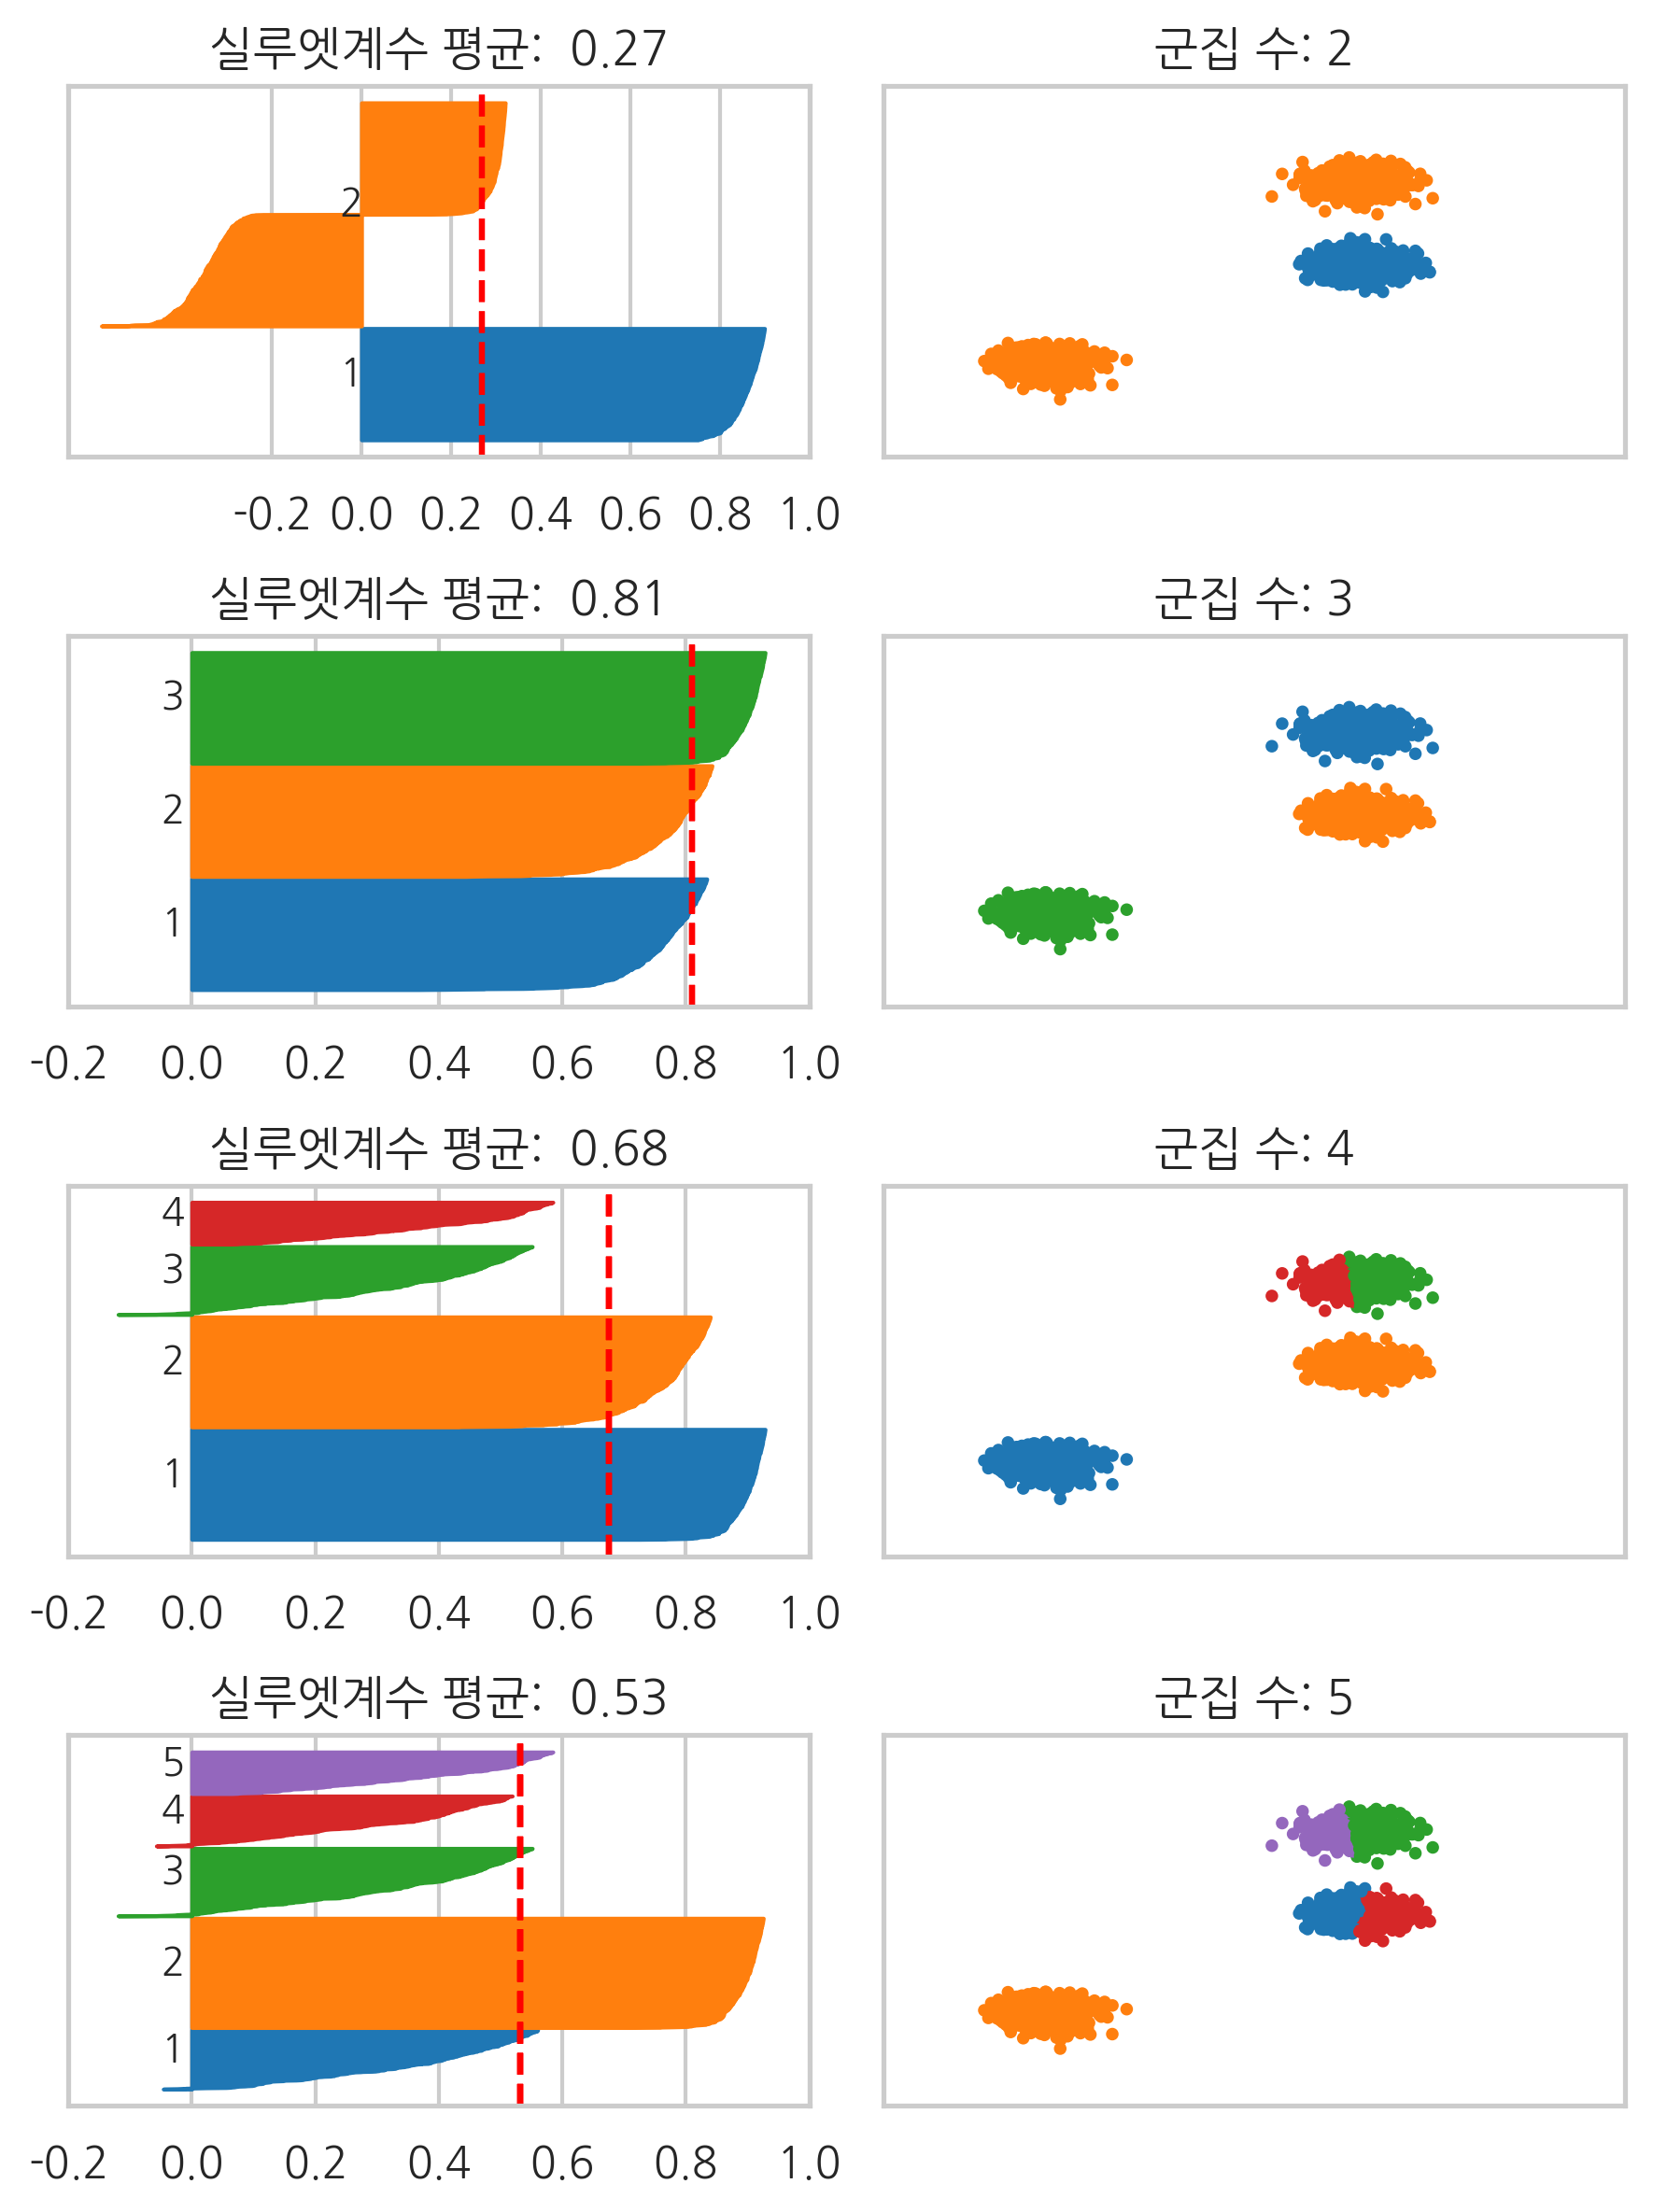

In [9]:
from sklearn.metrics import silhouette_samples

def plot_silhouette(data):
    X = StandardScaler().fit_transform(data[0])
    colors = plt.cm.tab10(np.arange(20, dtype=int))
    plt.figure(figsize=(6, 8))
    for i in range(4):
        model = SpectralClustering(n_clusters=i + 2, affinity="nearest_neighbors")
        cluster_labels = model.fit_predict(X)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        silhouette_avg = sample_silhouette_values.mean()

        plt.subplot(4, 2, 2 * i + 1)
        y_lower = 10
        for j in range(i + 2):
            jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
            jth_cluster_silhouette_values.sort()
            size_cluster_j = jth_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_j
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                              0, jth_cluster_silhouette_values,
                              facecolor=colors[j], edgecolor=colors[j])
            plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j + 1))
            plt.axvline(x=silhouette_avg, color="red", linestyle="--")
            plt.xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.yticks([])
            plt.title("실루엣계수 평균: {:5.2f}".format(silhouette_avg))
            y_lower = y_upper + 10


        plt.subplot(4, 2, 2 * i + 2)
        plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[cluster_labels])
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.title("군집 수: {}".format(i + 2))

    plt.tight_layout()
    plt.show()
    
plot_silhouette(blobs)

다만 실루엣계수는 군집의 형상이 복잡하거나 크기의 차이가 많이나면 정상적인 비교가 불가능하다.

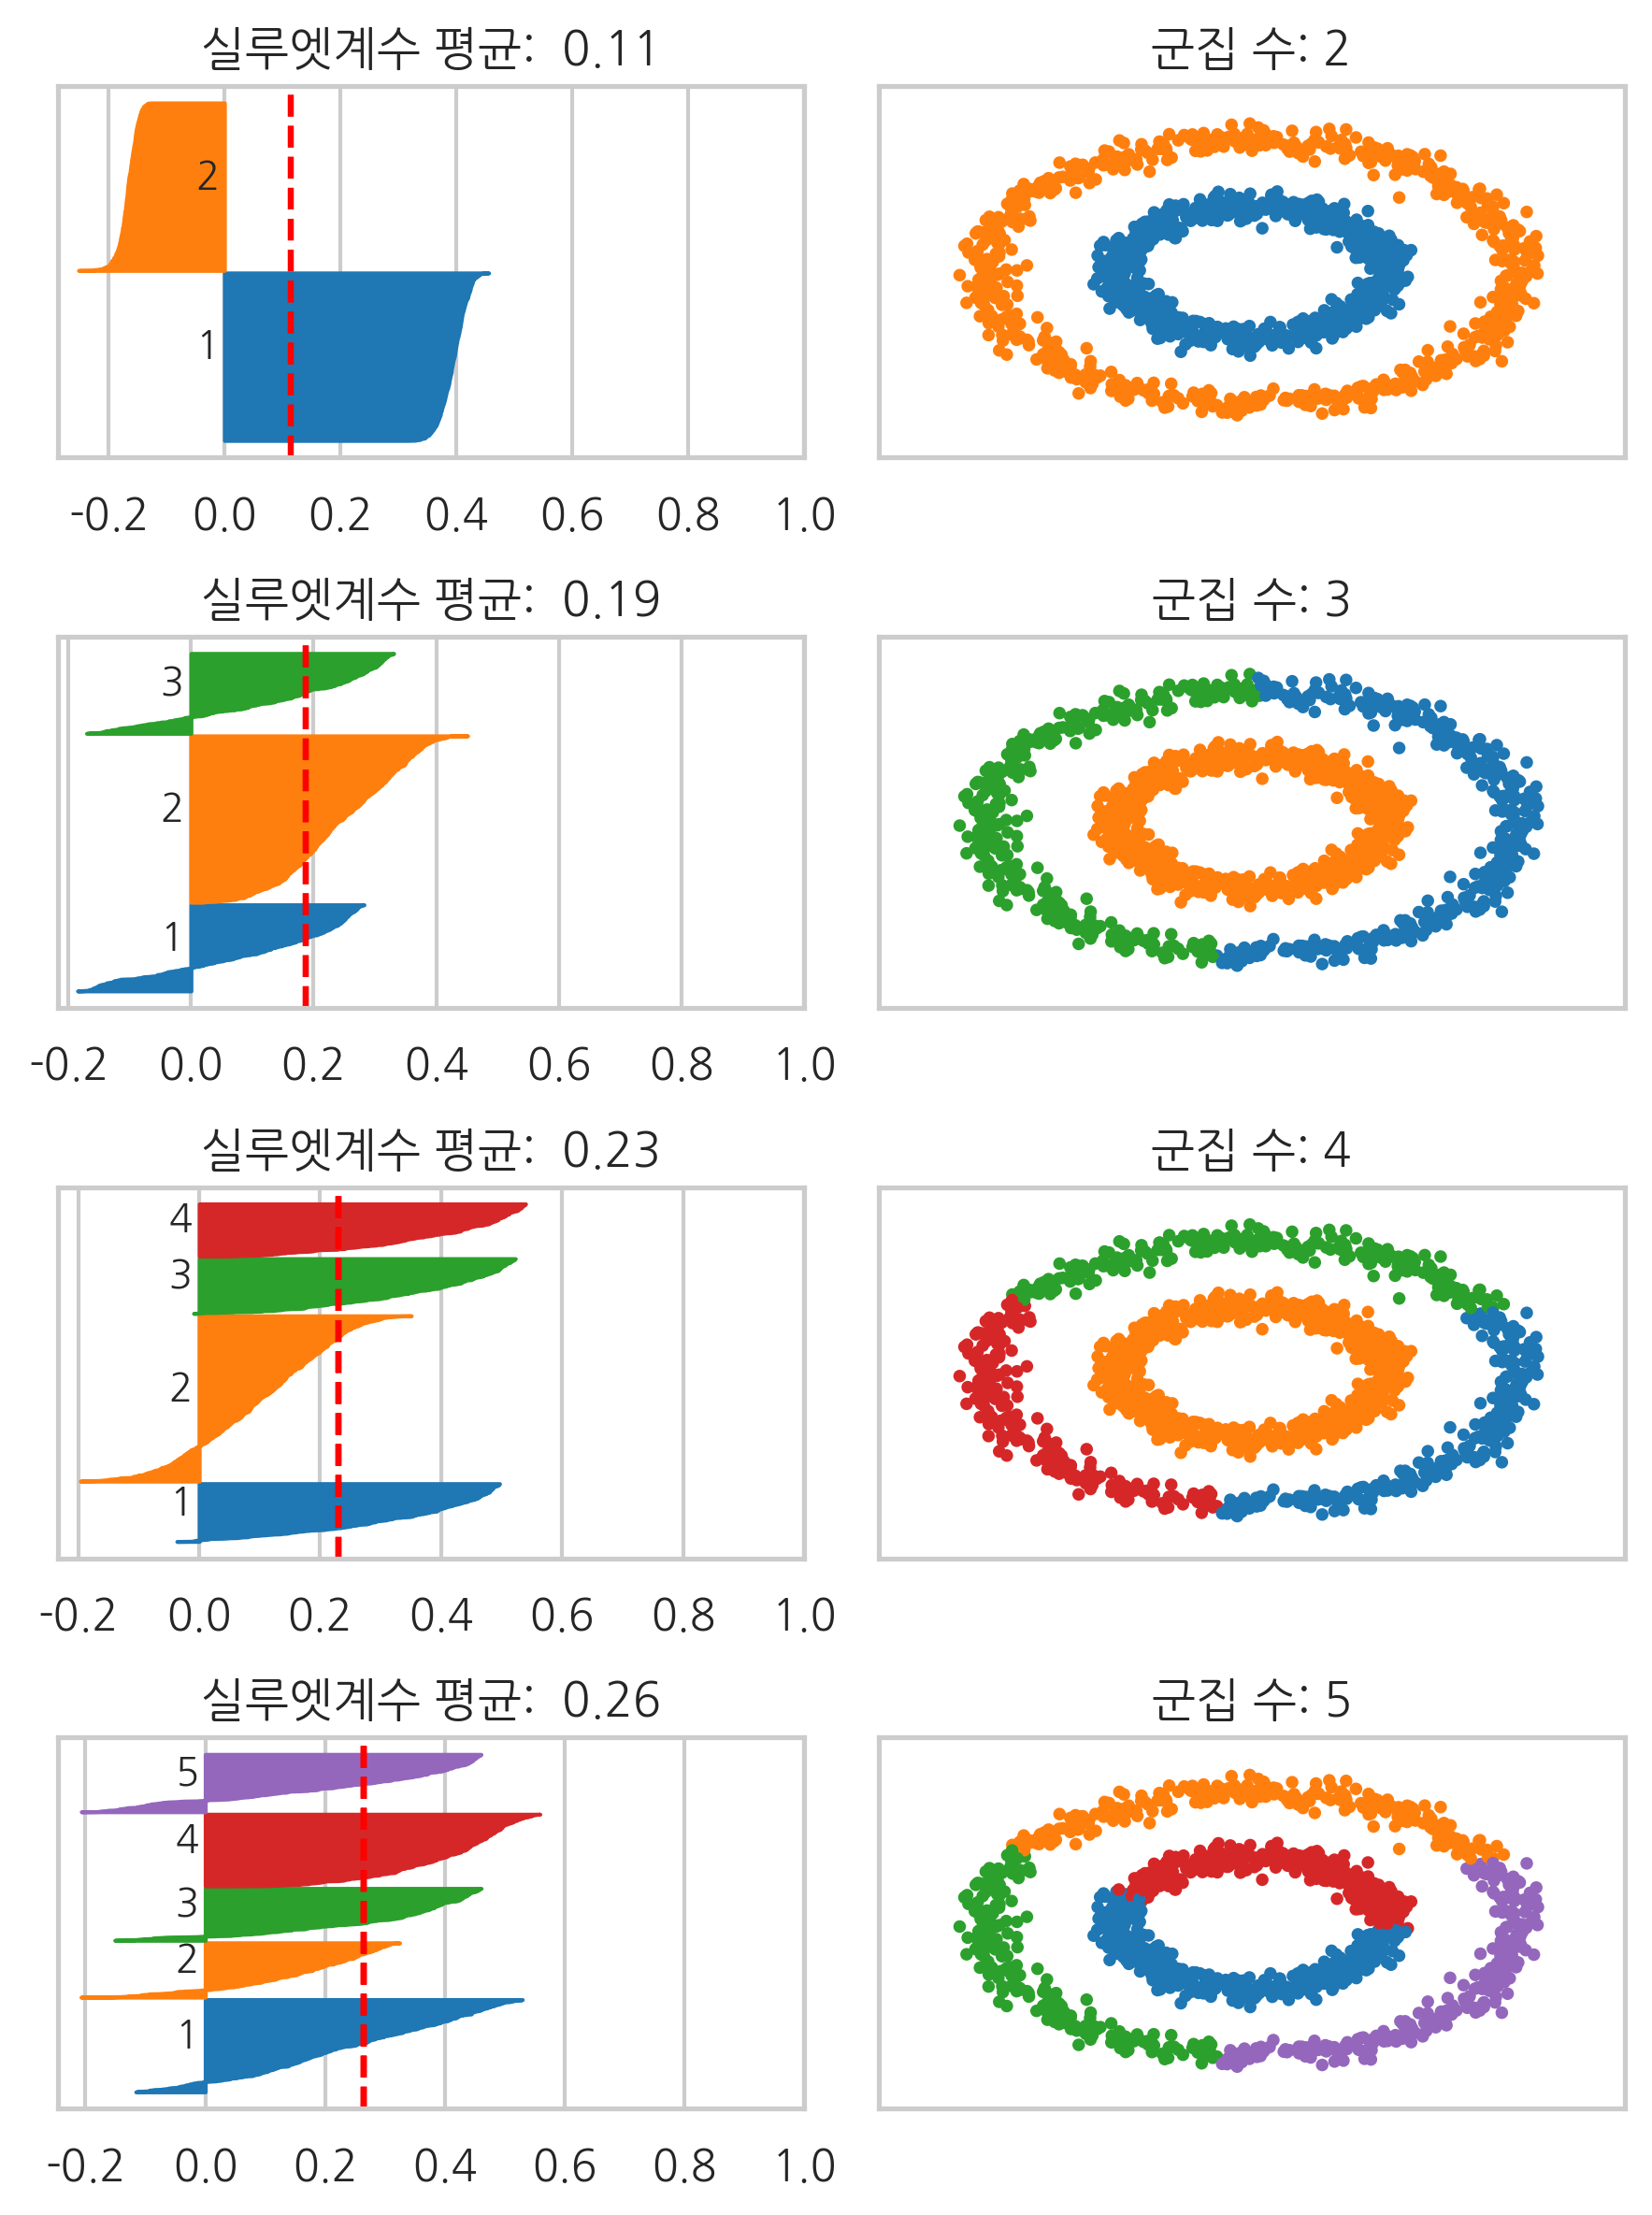

In [10]:
plot_silhouette(noisy_circles)